In [2]:
import multihist as mh
import numpy as np
import pickle as pk
import inference_interface as ii
import matplotlib.pyplot as plt
from itertools import product as iterproduct
from scipy.interpolate import interp1d

In [3]:
from dd_limit_plot import DD_result, find_dd_results

In [4]:
#lz_2024["sensitivity_median"]

In [5]:
def percplusmin(arr, percentile=50, cl=68, N=1000):
    per = np.percentile(arr, percentile)
    pers = [np.percentile(np.random.choice(arr, size=len(arr)), percentile) for _ in range(N)]
    pers = np.array(pers)
    perd = np.percentile(pers, 0.5*(100-cl))
    peru = np.percentile(pers, 100-0.5*(100-cl))
    return per, perd, peru

In [6]:
Rob_results = dict()
#Rob_results[("LNGS",1.,1.,"good", 40)] = 181.62
#Rob_results[("LNGS",10.,10.,"good", 40)] = 238.51
#Rob_results[("LNGS",1.,1.,"bad", 40)] = 858.76
#Rob_results[("LNGS",10.,10.,"bad", 40)] = 1000
#Rob_results[("SURF",1.,1.,"good", 40)] = 135.68
#Rob_results[("SURF",10.,10.,"good", 40)] = 167.02
#Rob_results[("SURF",1.,1.,"bad", 40)] = 653.59
#Rob_results[("SURF",10.,10.,"bad", 40)] = 690.68

#
Rob_results[("LNGS",1.,1.,1.,"good")] = 904.52
Rob_results[("LNGS",1.,1.,10.,"good")] = 10000
Rob_results[("SURF",1.,1.,1.,"good")] = 642.64
Rob_results[("SURF",1.,1.,10.,"good")] = 10000

Rob_results[("LNGS",1. ,1., 0.,"good")]  = 171.26
Rob_results[("LNGS",10.,10.,0.,"good")]  = 238.74
Rob_results[("LNGS",1., 1., 0.,"bad" )]  = 957.94
Rob_results[("LNGS",10.,10.,0.,"bad" )]  = 1199.58

Rob_results[("SURF",1. ,1., 0.,"good")]  = 137.18
Rob_results[("SURF",10.,10.,0.,"good")]  = 151.31
Rob_results[("SURF",1., 1., 0.,"bad" )]  = 721.50
Rob_results[("SURF",10.,10.,0.,"bad" )]  = 798.81

In [7]:
theory_ew_multiplet_dm = np.array([[2781.277743429261, 3.3856176791614125e-48,],
[2800.6127419445565, 2.0332469877822237e-47,],
[4693.564439647318, 4.772783437393608e-47,],
[9719.818023286707, 6.203980482349174e-47,],
[13428.336285993191, 1.8425343827261412e-46,],
[32473.488683593572, 3.282700884083845e-46,],
[47862.28375299604, 7.351945502504131e-46,],
[84709.93906335733, 1.1689981731077218e-45,],
[117739.63960943819, 2.0658942242794835e-45,],
[166423.79829686123, 3.0806258405837474e-45,],
[201255.00088972808, 4.641767420446145e-45,],
[255757.0491760662, 6.383493860265938e-45,],
[329502.34354863875, 8.759880389893944e-45]]).T
f_theory_ew_multiplet_dm = interp1d(theory_ew_multiplet_dm[0], theory_ew_multiplet_dm[1], bounds_error=False, fill_value=0.)

In [8]:
f_theory_ew_multiplet_dm(4000)

array(3.76903619e-47)

In [9]:
locations = ["LNGS","SURF"]
Pb214_rates = [1.,10.]
Kr85_rates  = [1.,10.]
neutron_rates =[1.,10.]
detector_performances = ["good","bad"]
livetimes = [5,10,20,50,75,100,150,200,500,700,1000]
wimp_mass = 5000

#pattern = "run_results/toymc_sensi_{detector_location:s}_{detector_performance:s}_Pb214_{Pb214_rate:.2f}_Kr85_{Kr85_rate:.2f}_livetime_{livetime:.0f}_wimp_mass_{wimp_mass:d}_poi_expectation_0.00.ii_*.h5"
pattern = "run_results/toymc_sensi_k0d32_{detector_location:s}_{detector_performance:s}_Pb214_{Pb214_rate:.2f}_Kr85_{Kr85_rate:.2f}_neutron_{neutron_rate:.2f}_livetime_{livetime:.0f}_wimp_mass_{wimp_mass:d}_poi_expectation_0.00.ii_*.h5"

In [10]:
lz_2024 = DD_result("WIMPSI_LZ_2024_privatecommunication*")
lz_2024_exposure = 4.2 #ty
lz_2024_values = {k:interp1d(lz_2024.wimp_mass, lz_2024[k], bounds_error=False, fill_value = np.inf)(wimp_mass) for k in "upper_limit,sensitivity_m2sigma,sensitivity_m1sigma,sensitivity_median,sensitivity_p1sigma,sensitivity_p2sigma".split(",")}

In [11]:
nufog_OHare = DD_result("nufog_OHare_2021*")

In [12]:
nufog_OHare_values = {k:interp1d(nufog_OHare.wimp_mass, nufog_OHare[k], bounds_error=False, fill_value = np.inf)(wimp_mass) for k in "nufloor,nufog_2d5,nufog_3d0".split(",")}

In [13]:
ress = dict()
lowest_xsecs = []
keys_for_lowest_xsecs = []
for location, Pb214_rate,  Kr85_rate, neutron_rate,  detector_performance in iterproduct(
    locations, Pb214_rates,Kr85_rates, neutron_rates, detector_performances
    ):
    res = []
    for livetime in livetimes:
        fn = pattern.format(
            detector_location=location, 
            Pb214_rate = Pb214_rate, 
            Kr85_rate = Kr85_rate,
            neutron_rate=neutron_rate,
            detector_performance = detector_performance,
            livetime=livetime, 
            wimp_mass = wimp_mass
        )
        try:
            res.append( (livetime, ii.toyfiles_to_numpy(fn)) )
        except Exception as e:
            #print("e",e)
            pass
    key = (location, Pb214_rate,  Kr85_rate, neutron_rate,  detector_performance,  wimp_mass)
    if 0<len(res):
        ress[key] = res
        lowest_xsecs.append(np.median(res[-1][1]["free"]["ul"] ))
        keys_for_lowest_xsecs.append(key)
    

In [14]:
lowest_xsecs = np.array(lowest_xsecs)
lowest_xsecs
keys_for_lowest_xsecs = [keys_for_lowest_xsecs[i] for i in lowest_xsecs.argsort()[::-1]]
lowest_xsecs = np.sort(lowest_xsecs)[::-1]


In [15]:
keys_for_lowest_xsecs

[('SURF', 1.0, 1.0, 10.0, 'bad', 5000),
 ('SURF', 1.0, 1.0, 10.0, 'good', 5000),
 ('LNGS', 1.0, 1.0, 10.0, 'bad', 5000),
 ('LNGS', 1.0, 1.0, 10.0, 'good', 5000),
 ('SURF', 1.0, 1.0, 1.0, 'bad', 5000),
 ('SURF', 10.0, 10.0, 1.0, 'bad', 5000),
 ('SURF', 10.0, 10.0, 1.0, 'good', 5000),
 ('SURF', 1.0, 1.0, 1.0, 'good', 5000),
 ('LNGS', 10.0, 10.0, 1.0, 'bad', 5000),
 ('LNGS', 1.0, 1.0, 1.0, 'bad', 5000),
 ('LNGS', 10.0, 10.0, 1.0, 'good', 5000),
 ('LNGS', 1.0, 1.0, 1.0, 'good', 5000)]

In [16]:
cmap = plt.colormaps.get_cmap("jet_r")

In [17]:
f_theory_ew_multiplet_dm(wimp_mass_ref)

array(3.76903619e-47)

k is missing ('SURF', 1.0, 1.0, 10.0, 'bad', 5000)
kk ('SURF', 1.0, 1.0, 10.0, 'good')
k is missing ('LNGS', 1.0, 1.0, 10.0, 'bad', 5000)
kk ('LNGS', 1.0, 1.0, 10.0, 'good')
k is missing ('SURF', 1.0, 1.0, 1.0, 'bad', 5000)
k is missing ('SURF', 10.0, 10.0, 1.0, 'bad', 5000)
k is missing ('SURF', 10.0, 10.0, 1.0, 'good', 5000)
kk ('SURF', 1.0, 1.0, 1.0, 'good')
k is missing ('LNGS', 10.0, 10.0, 1.0, 'bad', 5000)
k is missing ('LNGS', 1.0, 1.0, 1.0, 'bad', 5000)
k is missing ('LNGS', 10.0, 10.0, 1.0, 'good', 5000)
kk ('LNGS', 1.0, 1.0, 1.0, 'good')


<Figure size 640x480 with 0 Axes>

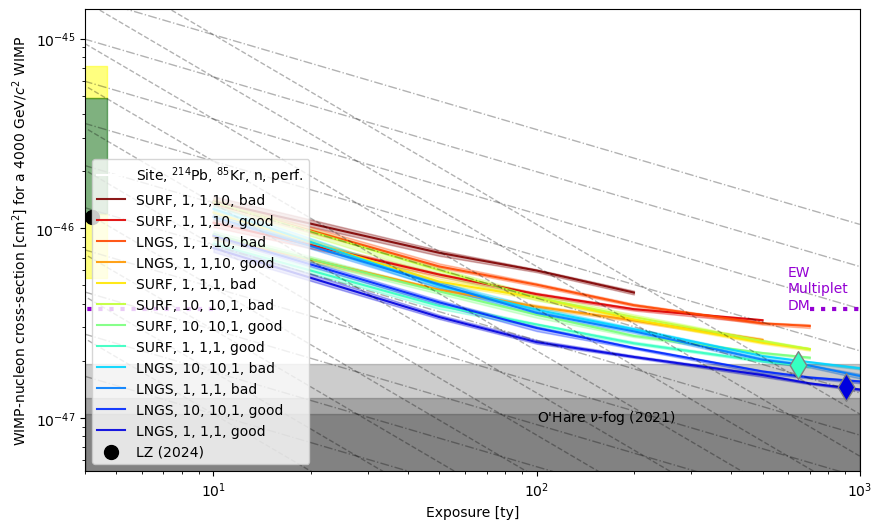

In [43]:
wimp_mass_ref = 4000

yscaling = wimp_mass_ref / wimp_mass



plt.clf()
fig, ax = plt.subplots(1,1,figsize=(10,6))
plt.plot([600],[3e-49],color="white",label= "Site, $^{214}$Pb, $^{85}$Kr, n, perf." )
for ii, k in enumerate(keys_for_lowest_xsecs):
    color = cmap(ii/len(lowest_xsecs))
    i = ress[k]
    lts = [x[0] for x in i]
    ulcis = [percplusmin(x[1]["free"]["ul"]*1e-45) for x in i]
    ulms = np.array([x[0] for x in ulcis])
    ulds = np.array([x[1] for x in ulcis])
    ulus = np.array([x[2] for x in ulcis])
    label = "{:s}, {:.0f}, {:.0f},{:.0f}, {:s}".format(k[0],k[1],k[2],k[3],k[4])
    #plt.plot(lts, ulms, marker="o", label=label)

    kk = (k[0],k[1],k[2],k[3],k[4])
    
    if True:
        plt.plot(lts,ulms*yscaling, label=label, alpha=0.9, color=color)
        plt.fill_between(lts,ulds*yscaling, ulus*yscaling, label="", alpha=0.3, color=color)
    if kk in Rob_results:
        print("kk",kk)
        lt = Rob_results[kk]
        fi = interp1d(lts, ulms*yscaling, bounds_error=False, fill_value=1.)
        plt.scatter([lt], [fi(lt)], marker="d", zorder=1000, color=color, s=200, edgecolor="gray")
    else:
        print("k is missing",k)

for ys in np.geomspace(1,100,10)*nufog_OHare_values["nufog_3d0"]*yscaling:
    x = np.linspace(1,1000,1000)
    plt.plot(x, (ys*10) * (1/x), color="k", alpha=0.3, linestyle="--", linewidth=1)
    plt.plot(x, (ys*np.sqrt(10)) * (1/np.sqrt(x) ), color="k", alpha=0.3, linestyle="-.", linewidth=1)


plt.fill_between(lz_2024_exposure + np.linspace(-0.5,0.5,2) , lz_2024_values["sensitivity_p1sigma"]*np.ones(2)*yscaling, lz_2024_values["sensitivity_p2sigma"]*yscaling, color="yellow", alpha=0.5)
plt.fill_between(lz_2024_exposure + np.linspace(-0.5,0.5,2) , lz_2024_values["sensitivity_m1sigma"]*np.ones(2)*yscaling, lz_2024_values["sensitivity_p1sigma"]*yscaling, color="darkgreen", alpha=0.5)
plt.fill_between(lz_2024_exposure + np.linspace(-0.5,0.5,2) , lz_2024_values["sensitivity_m2sigma"]*np.ones(2)*yscaling, lz_2024_values["sensitivity_m1sigma"]*yscaling, color="yellow", alpha=0.5)
plt.scatter([lz_2024_exposure], [lz_2024_values["upper_limit"]*yscaling], marker="o", color="k", s=100, label="LZ (2024)")

lts = np.linspace(4,1000,2)
plt.fill_between(lts, 1e-50*np.ones(2), nufog_OHare_values["nufog_3d0"]*yscaling, color="k", alpha=0.2)
plt.fill_between(lts, 1e-50*np.ones(2), nufog_OHare_values["nufog_2d5"]*yscaling, color="k", alpha=0.2)
plt.fill_between(lts, 1e-50*np.ones(2), nufog_OHare_values["nufloor"]*yscaling, color="k", alpha=0.2)

plt.text(100,0.5*nufog_OHare_values["nufloor"]*yscaling,"O'Hare $\\nu$-fog (2021)")

yd = nufog_OHare_values["nufog_3d0"]*yscaling * 0.5
yu = lz_2024_values["sensitivity_p2sigma"]*yscaling *2
plt.ylim(yd,yu)

plt.plot([700,1000], f_theory_ew_multiplet_dm(wimp_mass_ref)*np.ones(2), lw=3,color="darkviolet", linestyle=":")
plt.plot([1,10], f_theory_ew_multiplet_dm(wimp_mass_ref)*np.ones(2), lw=3,color="darkviolet", linestyle=":")
plt.text(600, f_theory_ew_multiplet_dm(wimp_mass_ref), "EW\nMultiplet\nDM", color="darkviolet")

#plt.ylim(1e-49,0.1e-46)
plt.xlim(lts[0], lts[-1])
plt.xscale("log")
plt.xlabel("Exposure [ty]")
plt.ylabel("WIMP-nucleon cross-section [cm$^2$] for a {:.0f} GeV$/c^2$ WIMP".format(wimp_mass_ref))
plt.yscale("log")
plt.legend(loc="lower left")
plt.savefig("Sensitivity_progress_wimpmass{:.0f}.png".format(wimp_mass_ref))
plt.show()

kk ('LNGS', 1.0, 1.0, 1.0, 'good')
kk ('SURF', 1.0, 1.0, 1.0, 'good')
k is missing ('LNGS', 10.0, 10.0, 1.0, 'good', 5000)
kk ('LNGS', 1.0, 1.0, 10, 'good')
k is missing ('LNGS', 1.0, 1.0, 1.0, 'bad', 5000)


<Figure size 640x480 with 0 Axes>

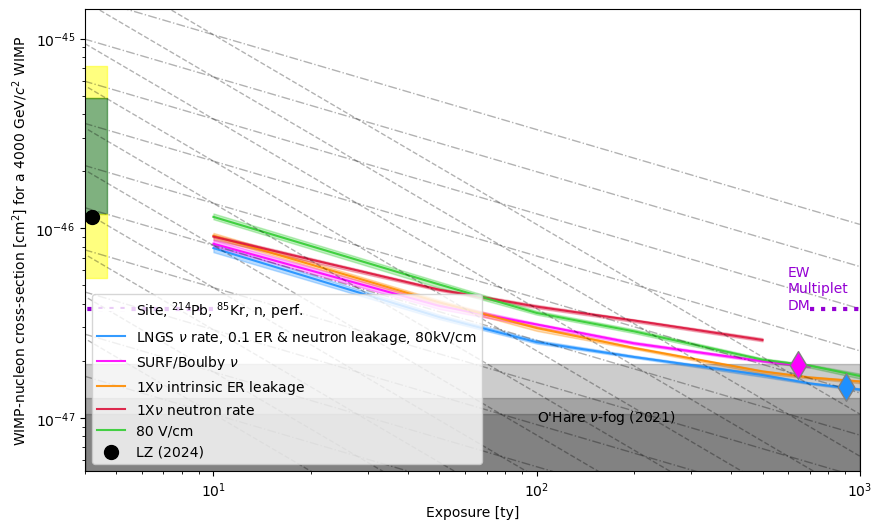

In [44]:
wimp_mass_ref = 4000

yscaling = wimp_mass_ref / wimp_mass


coloring = dict()
coloring[("LNGS", 1.,  1.,  1.,  "good",  5000)] = "dodgerblue"
coloring[("SURF", 1. , 1. , 1. , "good" , 5000)] = "magenta"
coloring[("LNGS", 10., 10., 1. , "good" , 5000)] = "darkorange"
coloring[("LNGS", 1. , 1. , 10 , "good" , 5000)] = "crimson"
coloring[("LNGS", 1. , 1. , 1. , "bad"  , 5000)] = "limegreen"

legends = dict()
legends[("LNGS", 1.,  1.,  1.,  "good",  5000)] = "LNGS $\\nu$ rate, 0.1 ER & neutron leakage, 80kV/cm"
legends[("SURF", 1. , 1. , 1. , "good" , 5000)] = "SURF/Boulby $\\nu$"
legends[("LNGS", 10., 10., 1. , "good" , 5000)] = "1X$\\nu$ intrinsic ER leakage"
legends[("LNGS", 1. , 1. , 10 , "good" , 5000)] = "1X$\\nu$ neutron rate"
legends[("LNGS", 1. , 1. , 1. , "bad"  , 5000)] = "80 V/cm"






plt.clf()
fig, ax = plt.subplots(1,1,figsize=(10,6))
plt.plot([600],[3e-49],color="white",label= "Site, $^{214}$Pb, $^{85}$Kr, n, perf." )
for k in coloring.keys():
    color = coloring[k]
    
    i = ress[k]
    lts = [x[0] for x in i]
    ulcis = [percplusmin(x[1]["free"]["ul"]*1e-45) for x in i]
    ulms = np.array([x[0] for x in ulcis])
    ulds = np.array([x[1] for x in ulcis])
    ulus = np.array([x[2] for x in ulcis])
    label = legends[k]
    #plt.plot(lts, ulms, marker="o", label=label)

    kk = (k[0],k[1],k[2],k[3],k[4])
    
    if True:
        plt.plot(lts,ulms*yscaling, label=label, alpha=0.9, color=color)
        plt.fill_between(lts,ulds*yscaling, ulus*yscaling, label="", alpha=0.3, color=color)
    if kk in Rob_results:
        print("kk",kk)
        lt = Rob_results[kk]
        fi = interp1d(lts, ulms*yscaling, bounds_error=False, fill_value=1.)
        plt.scatter([lt], [fi(lt)], marker="d", zorder=1000, color=color, s=200, edgecolor="gray")
    else:
        print("k is missing",k)

for ys in np.geomspace(1,100,10)*nufog_OHare_values["nufog_3d0"]*yscaling:
    x = np.linspace(1,1000,1000)
    plt.plot(x, (ys*10) * (1/x), color="k", alpha=0.3, linestyle="--", linewidth=1)
    plt.plot(x, (ys*np.sqrt(10)) * (1/np.sqrt(x) ), color="k", alpha=0.3, linestyle="-.", linewidth=1)


plt.fill_between(lz_2024_exposure + np.linspace(-0.5,0.5,2) , lz_2024_values["sensitivity_p1sigma"]*np.ones(2)*yscaling, lz_2024_values["sensitivity_p2sigma"]*yscaling, color="yellow", alpha=0.5)
plt.fill_between(lz_2024_exposure + np.linspace(-0.5,0.5,2) , lz_2024_values["sensitivity_m1sigma"]*np.ones(2)*yscaling, lz_2024_values["sensitivity_p1sigma"]*yscaling, color="darkgreen", alpha=0.5)
plt.fill_between(lz_2024_exposure + np.linspace(-0.5,0.5,2) , lz_2024_values["sensitivity_m2sigma"]*np.ones(2)*yscaling, lz_2024_values["sensitivity_m1sigma"]*yscaling, color="yellow", alpha=0.5)
plt.scatter([lz_2024_exposure], [lz_2024_values["upper_limit"]*yscaling], marker="o", color="k", s=100, label="LZ (2024)")

lts = np.linspace(4,1000,2)
plt.fill_between(lts, 1e-50*np.ones(2), nufog_OHare_values["nufog_3d0"]*yscaling, color="k", alpha=0.2)
plt.fill_between(lts, 1e-50*np.ones(2), nufog_OHare_values["nufog_2d5"]*yscaling, color="k", alpha=0.2)
plt.fill_between(lts, 1e-50*np.ones(2), nufog_OHare_values["nufloor"]*yscaling, color="k", alpha=0.2)

plt.text(100,0.5*nufog_OHare_values["nufloor"]*yscaling,"O'Hare $\\nu$-fog (2021)")

yd = nufog_OHare_values["nufog_3d0"]*yscaling * 0.5
yu = lz_2024_values["sensitivity_p2sigma"]*yscaling *2
plt.ylim(yd,yu)

plt.plot([700,1000], f_theory_ew_multiplet_dm(wimp_mass_ref)*np.ones(2), lw=3,color="darkviolet", linestyle=":")
plt.plot([1,10], f_theory_ew_multiplet_dm(wimp_mass_ref)*np.ones(2), lw=3,color="darkviolet", linestyle=":")
plt.text(600, f_theory_ew_multiplet_dm(wimp_mass_ref), "EW\nMultiplet\nDM", color="darkviolet")

#plt.ylim(1e-49,0.1e-46)
plt.xlim(lts[0], lts[-1])
plt.xscale("log")
plt.xlabel("Exposure [ty]")
plt.ylabel("WIMP-nucleon cross-section [cm$^2$] for a {:.0f} GeV$/c^2$ WIMP".format(wimp_mass_ref))
plt.yscale("log")
plt.legend(loc="lower left")
plt.savefig("Sensitivity_progress_selected_wimpmass{:.0f}.pdf".format(wimp_mass_ref))
plt.savefig("Sensitivity_progress_selected_wimpmass{:.0f}.png".format(wimp_mass_ref))

plt.show()

In [38]:
keys_for_lowest_xsecs

[('SURF', 1.0, 1.0, 10.0, 'bad', 5000),
 ('SURF', 1.0, 1.0, 10.0, 'good', 5000),
 ('LNGS', 1.0, 1.0, 10.0, 'bad', 5000),
 ('LNGS', 1.0, 1.0, 10.0, 'good', 5000),
 ('SURF', 1.0, 1.0, 1.0, 'bad', 5000),
 ('SURF', 10.0, 10.0, 1.0, 'bad', 5000),
 ('SURF', 10.0, 10.0, 1.0, 'good', 5000),
 ('SURF', 1.0, 1.0, 1.0, 'good', 5000),
 ('LNGS', 10.0, 10.0, 1.0, 'bad', 5000),
 ('LNGS', 1.0, 1.0, 1.0, 'bad', 5000),
 ('LNGS', 10.0, 10.0, 1.0, 'good', 5000),
 ('LNGS', 1.0, 1.0, 1.0, 'good', 5000)]

k is missing ('SURF', 1.0, 1.0, 10.0, 'bad', 5000)
k is missing ('SURF', 1.0, 1.0, 10.0, 'good', 5000)
k is missing ('LNGS', 1.0, 1.0, 10.0, 'bad', 5000)
k is missing ('LNGS', 1.0, 1.0, 10.0, 'good', 5000)
k is missing ('SURF', 1.0, 1.0, 1.0, 'bad', 5000)
k is missing ('SURF', 10.0, 10.0, 1.0, 'bad', 5000)
k is missing ('SURF', 10.0, 10.0, 1.0, 'good', 5000)
k is missing ('SURF', 1.0, 1.0, 1.0, 'good', 5000)
k is missing ('LNGS', 10.0, 10.0, 1.0, 'bad', 5000)
k is missing ('LNGS', 10.0, 10.0, 1.0, 'good', 5000)


<Figure size 640x480 with 0 Axes>

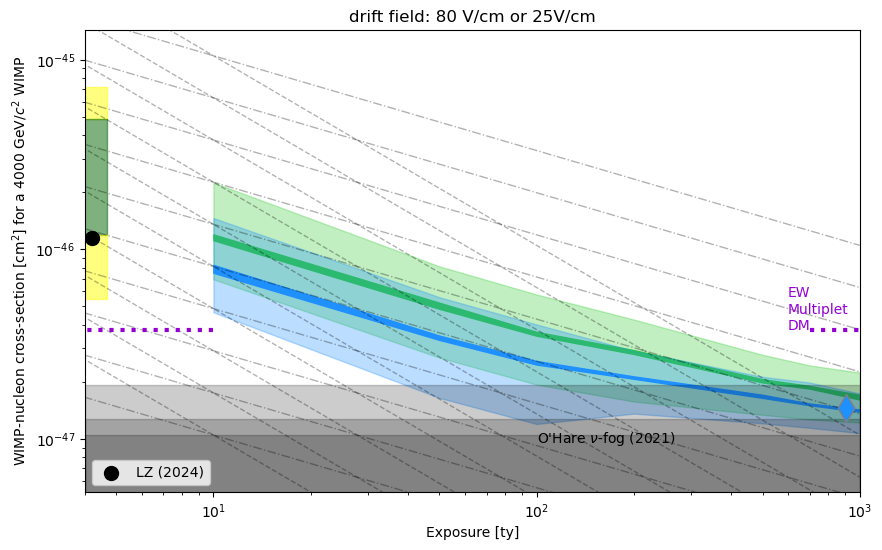

In [49]:
wimp_mass_ref = 4000

yscaling = wimp_mass_ref / wimp_mass



plt.clf()
fig, ax = plt.subplots(1,1,figsize=(10,6))
#plt.plot([600],[3e-49],color="white",label= "Site, $^{214}$Pb, $^{85}$Kr, n, perf." )


coloring = dict(
    location= lambda k: "magenta" if k[0] == "SURF" else "dodgerblue",
    intrinsic= lambda k: "darkorange" if (k[1] == 10.0) & (k[2] == 10.0) else "dodgerblue",
    neutron= lambda k: "crimson" if k[3] == 10. else "dodgerblue",
    performance= lambda k: "limegreen" if k[4] == "bad" else "dodgerblue"                                            
)


labels = dict(
    location = "Placement: LNGS or BOULBY/SURF",
    intrinsic = "ER leakage: 0.1 or equal to atmospheric $\\nu$",
    neutron = "Neutron rate: 0.1 or equal to atmospheric $\\nu$",
    performance = "drift field: 80 V/cm or 25V/cm",
)

best_key = ("LNGS",1.,1.,1.,"good",5000)
keys_to_plot = dict(
    location    = [best_key, ("SURF", 1. , 1. , 1. , "good" , 5000)],
    intrinsic   = [best_key, ("LNGS", 10., 10., 1. , "good" , 5000)],
    neutron     = [best_key, ("LNGS", 1. , 1. , 10 , "good" , 5000)],
    performance = [best_key, ("LNGS", 1. , 1. , 1. , "bad"  , 5000)]
    
)
    
direction = "performance"

for ii, k in enumerate(keys_for_lowest_xsecs):
    if k in keys_to_plot.get(direction, keys_for_lowest_xsecs):
        color = coloring[direction](k)
        i = ress[k]
        lts = [x[0] for x in i]
        ulcis = [percplusmin(x[1]["free"]["ul"]*1e-45) for x in i]
        ulms = np.array([x[0] for x in ulcis])
        ulds = np.array([x[1] for x in ulcis])
        ulus = np.array([x[2] for x in ulcis])

        brbad = np.array([percplusmin(x[1]["free"]["ul"]*1e-45, percentile=15)[0] for x in i])
        brbau = np.array([percplusmin(x[1]["free"]["ul"]*1e-45, percentile=85)[0] for x in i])
        
        
            
        label = "{:s}, {:.0f}, {:.0f},{:.0f}, {:s}".format(k[0],k[1],k[2],k[3],k[4])
        #plt.plot(lts, ulms, marker="o", label=label)
        kk = (k[0],k[1],k[2],k[3],k[4])
        
        plt.fill_between(lts,brbad*yscaling, brbau*yscaling, label="", alpha=0.3, color=color)
        #plt.plot(lts,ulms*yscaling, label="", alpha=0.9, color=color)
        plt.fill_between(lts,ulds*yscaling, ulus*yscaling, label="", alpha=1, color=color)
        if kk in Rob_results:
            lt = Rob_results[kk]
            fi = interp1d(lts, ulms*yscaling, bounds_error=False, fill_value=1.)
            plt.scatter([lt], [fi(lt)], marker="d", zorder=1000, color=color, s=200, edgecolor="gray")
    else:
        print("k is missing",k)

for ys in np.geomspace(1,100,10)*nufog_OHare_values["nufog_3d0"]*yscaling:
    x = np.linspace(1,1000,1000)
    plt.plot(x, (ys*10) * (1/x), color="k", alpha=0.3, linestyle="--", linewidth=1)
    plt.plot(x, (ys*np.sqrt(10)) * (1/np.sqrt(x) ), color="k", alpha=0.3, linestyle="-.", linewidth=1)


plt.fill_between(lz_2024_exposure + np.linspace(-0.5,0.5,2) , lz_2024_values["sensitivity_p1sigma"]*np.ones(2)*yscaling, lz_2024_values["sensitivity_p2sigma"]*yscaling, color="yellow", alpha=0.5)
plt.fill_between(lz_2024_exposure + np.linspace(-0.5,0.5,2) , lz_2024_values["sensitivity_m1sigma"]*np.ones(2)*yscaling, lz_2024_values["sensitivity_p1sigma"]*yscaling, color="darkgreen", alpha=0.5)
plt.fill_between(lz_2024_exposure + np.linspace(-0.5,0.5,2) , lz_2024_values["sensitivity_m2sigma"]*np.ones(2)*yscaling, lz_2024_values["sensitivity_m1sigma"]*yscaling, color="yellow", alpha=0.5)
plt.scatter([lz_2024_exposure], [lz_2024_values["upper_limit"]*yscaling], marker="o", color="k", s=100, label="LZ (2024)")

lts = np.linspace(4,1000,2)
plt.fill_between(lts, 1e-50*np.ones(2), nufog_OHare_values["nufog_3d0"]*yscaling, color="k", alpha=0.2)
plt.fill_between(lts, 1e-50*np.ones(2), nufog_OHare_values["nufog_2d5"]*yscaling, color="k", alpha=0.2)
plt.fill_between(lts, 1e-50*np.ones(2), nufog_OHare_values["nufloor"]*yscaling, color="k", alpha=0.2)

plt.text(100,0.5*nufog_OHare_values["nufloor"]*yscaling,"O'Hare $\\nu$-fog (2021)")

yd = nufog_OHare_values["nufog_3d0"]*yscaling * 0.5
yu = lz_2024_values["sensitivity_p2sigma"]*yscaling *2
plt.ylim(yd,yu)

plt.plot([700,1000], f_theory_ew_multiplet_dm(wimp_mass_ref)*np.ones(2), lw=3,color="darkviolet", linestyle=":")
plt.plot([1,10], f_theory_ew_multiplet_dm(wimp_mass_ref)*np.ones(2), lw=3,color="darkviolet", linestyle=":")
plt.text(600, f_theory_ew_multiplet_dm(wimp_mass_ref), "EW\nMultiplet\nDM", color="darkviolet")

#plt.ylim(1e-49,0.1e-46)
plt.xlim(lts[0], lts[-1])
plt.xscale("log")
plt.xlabel("Exposure [ty]")
plt.ylabel("WIMP-nucleon cross-section [cm$^2$] for a {:.0f} GeV$/c^2$ WIMP".format(wimp_mass_ref))
plt.yscale("log")
plt.legend(loc="lower left")
plt.title(labels.get(direction, direction))
plt.savefig("Sensitivity_progress_wimpmass{:.0f}_{:s}.pdf".format(wimp_mass_ref, direction))
plt.savefig("Sensitivity_progress_wimpmass{:.0f}_{:s}.png".format(wimp_mass_ref, direction))

plt.show()

In [12]:
uls = i[0][1]["free"]["ul"]*1e-45

In [15]:
np.random.choice(uls)

np.float64(3.814283920379063e-49)

In [17]:
def percplusmin(arr, percentile=50, cl=68, N=1000):
    per = np.percentile(arr, percentile)
    pers = [np.percentile(np.random.choice(arr, size=len(arr)), percentile) for _ in range(N)]
    pers = np.array(pers)
    perd = np.percentile(pers, 0.5*(100-cl))
    peru = np.percentile(pers, 100-0.5*(100-cl))
    return per, perd, peru

In [18]:
percplusmin(uls)

(np.float64(6.984419066423143e-49),
 np.float64(6.750298335831365e-49),
 np.float64(7.350881889478266e-49))